# Import statements
#### source: https://www.datacamp.com/community/tutorials/cnn-tensorflow-python#cnn
##### dependencies: Python 3.6, tensorflow 1.14

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.examples.tutorials.mnist import input_data --> I dont have this
%matplotlib inline
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

C:\Users\Liam\.conda\envs\buzz\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Liam\.conda\envs\buzz\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Liam\.conda\envs\buzz\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Liam\.conda\envs\buzz\lib\site-packages\tensorflow\python\framework\dtypes.py:5

# Import data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(*x_train.shape,1)
x_test = x_test.reshape(*x_test.shape,1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
print("Training set (images) shape: {shape}".format(shape=x_train.shape))
print("Training set (labels) shape: {shape}".format(shape=y_train.shape))

Training set (images) shape: (60000, 28, 28, 1)
Training set (labels) shape: (60000, 10)


# Hyperparameter definition

In [3]:
#based on prev training 4 epochs minimizes overfitting
epochs = 4
learning_rate = 0.001
batch_size = 64

# MNIST data input (img shape: 28*28)
n_input = 28

# MNIST total classes (0-9 digits)
n_classes = 10

# only 1 channel
n_channels = 1

# Set up TF graph inputs

In [4]:
#tf.compat.v1.disable_eager_execution() # using TF1 without eager execution
x = tf.placeholder("float", [None, n_input,n_input,n_channels])
y = tf.placeholder("float", [None, n_classes])

# Conv layer and maxpool layer definition

In [5]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

# Weight/bias for network layers definition

In [6]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()),
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()),
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()),
    #after 3 2x2 max pooling 28x28 input images down-sampled to 4x4 = round(((28/2)/2)/2)
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()),
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# TF graph definition: 3 conv layers (32,64,128 3x3 filters)
#                                    ea. conv layer followed by 2x2 maxpool
#                                    then a fully connected layer
#                                    which connects to the 10 output neurons

In [7]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term.
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# Loss fn and optimizer definition

In [8]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Graph nodes for model evaluation, accuracy

In [9]:
#Here, you check whether the index of the maximum value of the predicted image is equal to the actual labeled image. And both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# initialize graph and kick off train/test loop

## calculates test loss every epoch

In [10]:
# Initializing the variables
init = tf.compat.v1.global_variables_initializer()

#test/train loop
with tf.compat.v1.Session() as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(epochs):
        for batch in range(len(x_train)//batch_size):
            batch_x = x_train[batch*batch_size:min((batch+1)*batch_size,len(x_train))]
            batch_y = y_train[batch*batch_size:min((batch+1)*batch_size,len(y_train))]    
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
        print("Epoch " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: x_test,y : y_test})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Epoch 0, Loss= 0.042489, Training Accuracy= 0.99219
Optimization Finished!
Testing Accuracy: 0.97920
Epoch 1, Loss= 0.008012, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98500
Epoch 2, Loss= 0.006311, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98700
Epoch 3, Loss= 0.002446, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98490
Epoch 4, Loss= 0.000884, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98690
Epoch 5, Loss= 0.016462, Training Accuracy= 0.99219
Optimization Finished!
Testing Accuracy: 0.98070
Epoch 6, Loss= 0.003540, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98670
Epoch 7, Loss= 0.001069, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98940
Epoch 8, Loss= 0.001421, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98330
Epoch 9, Loss= 0.000018, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy

# Plot test/train loss to evaluate under/over fitting

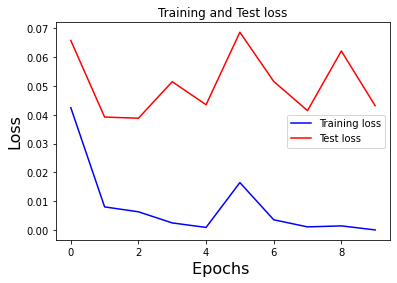

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

# Plot test/train acc to evaluate under/over fitting

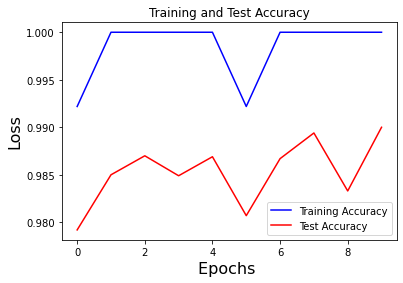

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()